In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [34]:
# Define hyperparameters for the network. 
N = 256 # Number of neurons in the network
d = 3 # Number of spatial dimensions that the network is embedded in
input_dimension = 10 # Number of input neurons
output_dimension = 1 # Number of output neurons
T = 10 # Total time of simulation
dt = 0.1 # Time step parameter
T_steps = int(T/dt) # Number of time steps
tau = 1 # Time constant parameter
sigma = 0.1 # Noise parameter
alpha = dt/tau # Update parameter
weight_threshold = 0.01 # Threshold for synaptic weights

gam_prop = 0.01 # Propagation penalisation coefficient
gam_syn = 0.01 # Synaptic transmission penalisation coefficient


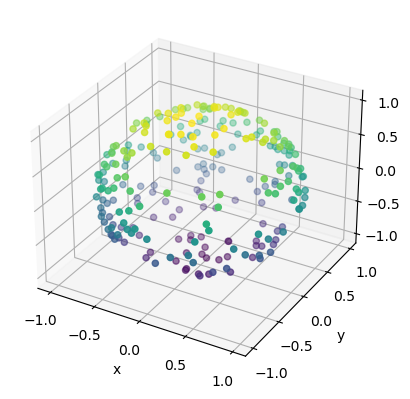

In [35]:
# Sample the position of the neurons in the network.
# The neurons are placed on a d-dimensional sphere of radius 1. 
# The neurons positions are sampled randomly and uniformly from the sphere.

# Generate random points on the sphere by first sampling d-dimensional isotropic Gaussians
# and then normalizing the resulting vectors to have unit length.
P = np.random.randn(N,d)
P = P / np.linalg.norm(P, axis=1, keepdims=True)

# Plot the neurons positions when d = 3.
# The neurons are coloured according to their z value.
if d == 3:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(P[:,0], P[:,1], P[:,2], marker='o', c=P[:,2], cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

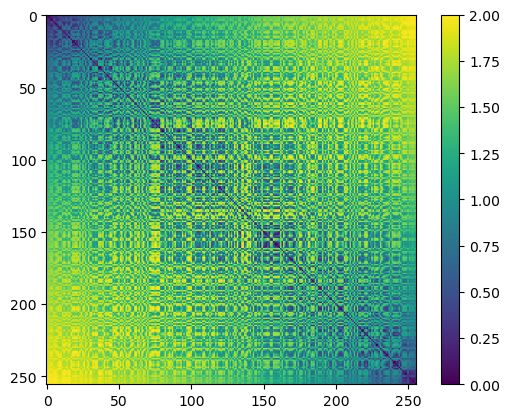

In [36]:
# Now compute the distance matrix D, where D[i,j] is the distance between the i-th and j-th neuron.
D = np.sqrt(np.sum((P[:,None,:] - P[None,:,:])**2, axis=-1))

# Sort the neurons according to their distance from the first neuron.
# This is done to make the visualization of the network more appealing.
idx = np.argsort(D[0,:])
D_sorted = D[idx,:][:,idx]

# Plot the sorted distance matrix.
plt.imshow(D_sorted, vmin=0, vmax=2)
plt.colorbar()
plt.show()

# Lastly, convert D into a torch tensor.
D = torch.tensor(D, dtype=torch.float, device=DEVICE)

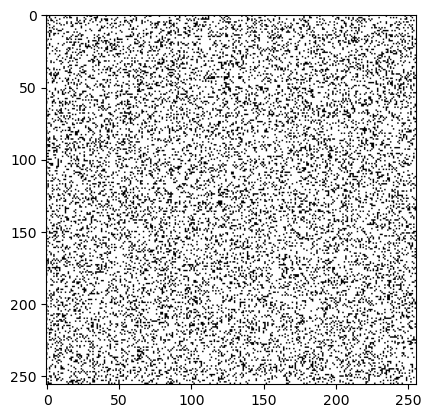

In [37]:
# Next, compute the initial adjacency matrix A of the graph.
# The random graph is generated by connecting each pair of neurons with probability p, i.e. an Erdős–Rényi graph.
# p is small so that the graph is sparse. 

p = 0.2 # Probability of connection between two neurons
A = torch.rand(N,N, device = DEVICE) < p

# Plot the adjacency matrix, where white pixels represent 0s and black pixels represent 1s.
plt.imshow(A, cmap='gray_r', vmin=0, vmax=1)

In [27]:
# Define the neural network. 
class sgRNN(nn.Module):
    def __init__(self, N):
        super().__init__()
        self.N = N
        self.nonlinearity = 'relu'
        
        # Define the weight matrices for the network
        self.Layers = nn.ModuleDict({
            "input": nn.Linear(input_dimension, N, bias = False),
            "recurrent": nn.Linear(N, N, bias = True),
            "output": nn.Linear(N, output_dimension, bias = True)
        })
        
        # Initialise the recurrent weight layer
        gain = nn.init.calculate_gain(self.nonlinearity) 
        std = gain/np.sqrt(N * p)
        nn.init.normal_(self.Layers["recurrent"].weight, mean=0, std=std)
        # Apply the adjacency matrix A to the recurrent weight matrix
        self.apply_mask(A)
    
    def plot_weight_matrix(self):
        plt.imshow(self.Layers["recurrent"].weight.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
        plt.colorbar()
        plt.show()

    def apply_mask(self, mask):
        self.Layers["recurrent"].weight = nn.Parameter(mask * self.Layers["recurrent"].weight) 

    def forward(self, h, x):
        # The forward function takes in:
        # (i) A batch of inputs x of shape (batch_size, input_dimension)
        # (ii) A batch of hidden states h of shape (batch_size, N)

        # The output of the function is a batch of sequence outputs y of shape (batch_size, output_dimension)
        # and a batch of hidden states h of shape (batch_size, N)

        h_new = (1 - alpha)*h + alpha*F.relu( self.Layers["input"](x) + self.Layers["recurrent"](h) )
        y = self.Layers["output"](h_new)
        return y, h_new


In [30]:
sg_net = sgRNN(N)
print(sg_net.state_dict().keys())

odict_keys(['Layers.input.weight', 'Layers.recurrent.weight', 'Layers.recurrent.bias', 'Layers.output.weight', 'Layers.output.bias'])


In [ ]:
# Build the training loop
def train_one_episode(model, optimizer, loss_function, X, Y_tar):
    # Zero out the optimiser gradients
    optimizer.zero_grad()

    # The input X has size (batch_size, input_dimension, T_steps)

    # Initialise the hidden state h
    h = torch.zeros(X.shape[0], N, device=DEVICE)

    # Initialise the output container of size (batch_size, output_dimension, T_steps)
    Y = torch.zeros(X.shape[0], output_dimension, T_steps, device=DEVICE)

    # Initialise the regulariser term
    reg_loss = 0

    # Iterate through the sequence of inputs X
    # At each time step, we compute the output of the network and update the hidden state as well as the base loss and the regulariser term
    for t in range(T_steps):
        Y[:,:,t], h = model(h, X[:,:,t])
        # The regularisation term 
        reg_loss = reg_loss + gam_prop * torch.sum( (A*D)@h ) + gam_syn * torch.sum( torch.abs(model.Layers["recurrent"].weight)@h )
    
    # Compute the loss
    loss = loss_function(Y, Y_tar) + reg_loss
    
    # Backpropagate the loss
    loss.backward()
    
    # Perform the weight updates
    optimizer.step()

    # Update the adjacency matrix A by thresholding the recurrent weight matrix
    A = torch.abs(model.Layers["recurrent"].weight.detach()) > weight_threshold

    # After each training epoch, we apply the mask
    model.apply_mask(A)
    
    return loss.item()